In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator, MultipleLocator
from google.cloud import bigquery
import retentioneering as rt
from retentioneering.eventstream import Eventstream
import datetime as dt
import re
import math

In [2]:
client = bigquery.Client()

In [3]:
start_date = '2025-07-01'
end_date = '2025-07-31'

In [4]:
after_iap = f"""
WITH base AS (
SELECT
    s2.event_date AS first_date,
    s2.country,
    s2.platform,
    DATE_DIFF(s1.event_date, s2.event_date, DAY) AS cohort_day,
    s1.*,
    ROW_NUMBER() OVER(PARTITION BY s1.user_pseudo_id ORDER BY s1.event_timestamp ASC) AS iap_order
FROM `{project_id}.{schema_id}.in_app_purchase` s1
JOIN `{project_id}.{schema_id}.first_open` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s1.event_date >= s2.event_date
WHERE s2.event_date >= DATE('{start_date}')
    AND s2.event_date <= DATE('{end_date}')
)
, base1 AS (
SELECT
    user_pseudo_id,
    event_timestamp,
    product_id,
FROM base
WHERE iap_order = 1
)
SELECT
  s1.user_pseudo_id,
  s1.event_timestamp AS ts_first_iap,
  product_id AS first_product_iap,
  s2.event_name,
  s2.event_date,
  s2.event_timestamp
FROM base1 s1
LEFT JOIN `{project_id}.{schema_id}.user_fact` s2
  ON s1.user_pseudo_id = s2.user_pseudo_id
  AND s2.event_timestamp >= s1.event_timestamp
WHERE s2.event_name IN ('in_app_purchase', 'user_engagement', 'screen_view', 'app_exception', 'first_open')
ORDER BY user_pseudo_id, ts_first_iap, event_timestamp
"""
after_iap = client.query(after_iap).to_dataframe()
after_iap['user_pseudo_id'].nunique()

438

In [ ]:
last_play_date = after_iap.groupby('user_pseudo_id')['event_date'].max().reset_index()
today = pd.Timestamp.today().normalize()
last_play_date['event_date'] = pd.to_datetime(last_play_date['event_date'])
last_play_date['days_since_last_play'] = (today - last_play_date['event_date']).dt.days
last_play_date['drop'] = np.where(
    last_play_date['days_since_last_play'] >= 3,
    'Drop',
    'Active'
)
last_play_date[last_play_date['drop'] == 'Drop']['user_pseudo_id'].unique().tolist()

In [6]:
# 1) Lấy tập user cần thêm hàng 'drop'
drop_ids = set(
    last_play_date.loc[last_play_date['drop'] == 'Drop', 'user_pseudo_id'].unique()
)

# 2) Giữ lại chỉ những user có mặt trong df
cand = after_iap[after_iap['user_pseudo_id'].isin(drop_ids)]

# 3) Lấy index của hàng có event_timestamp lớn nhất theo từng user
#    (nếu trùng max, idxmax() trả về dòng đầu tiên trong số đó)
idx_last = cand.groupby('user_pseudo_id')['event_timestamp'].idxmax()

# 4) Tạo bản sao các hàng max và chỉnh sửa theo yêu cầu
new_rows = after_iap.loc[idx_last].copy()
new_rows['event_name'] = 'drop'  # đặt tên sự kiện
# đảm bảo giữ dtype Int64 (nullable integer) rồi +1000
new_rows['event_timestamp'] = new_rows['event_timestamp'].astype('Int64') + 1000

# 5) Gộp trở lại
after_iap_out = pd.concat([after_iap, new_rows], ignore_index=True)

In [7]:
final_data = after_iap_out[(after_iap_out['event_name'] == 'in_app_purchase') | (after_iap_out['event_name'] == 'drop')][['first_product_iap', 'user_pseudo_id', 'event_timestamp', 'event_name']].reset_index(drop=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_14040\2754790358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iap_stream.rename(columns={


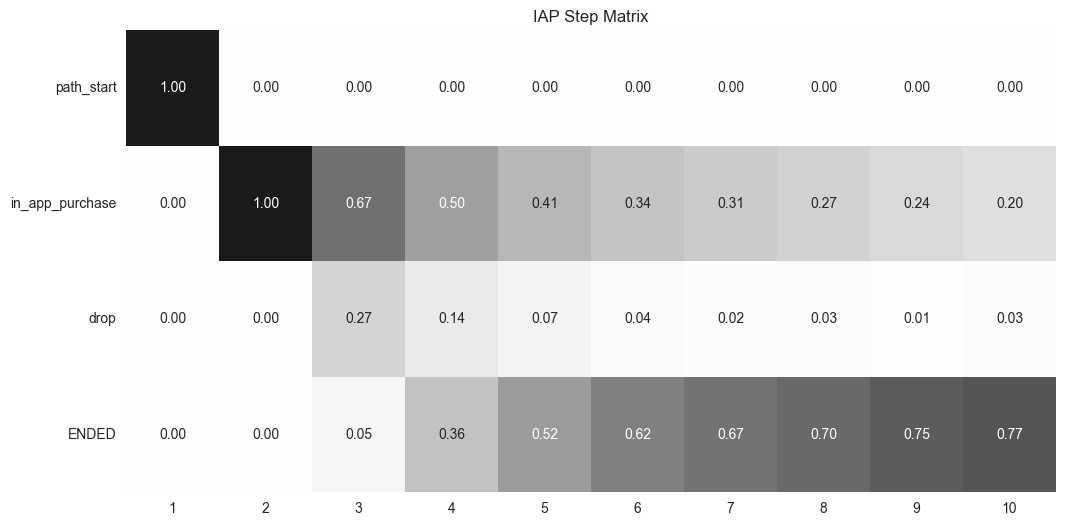

In [8]:
iap_stream = final_data[['user_pseudo_id', 'event_name', 'event_timestamp']]
iap_stream.rename(columns={
    'user_pseudo_id': 'user_id',
    'event_timestamp': 'timestamp',
    'event_name': 'event'
}, inplace=True)

ios_step = Eventstream(iap_stream).step_matrix(
    max_steps=10,
    show_plot=False,
)

ax = ios_step.plot()
fig = ax.get_figure()
fig.set_size_inches(12, 6)
ax.set_title("IAP Step Matrix")
plt.show()

In [9]:
Eventstream(iap_stream).step_sankey(
    max_steps=10,
    show_plot=True
)

Trong số những người dùng có phát sinh IAP:
- Khoảng 67% người dùng sẽ mua tiếp gói IAP thứ hai
- Khoảng 28% người dùng sẽ drop
- Khoảng 5% người dùng không drop cũng không mua tiếp gói IAP nào nữa

# Journey của nhóm mua IAP gói Remove Ads đầu tiên

C:\Users\PC\AppData\Local\Temp\ipykernel_14040\2085639495.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



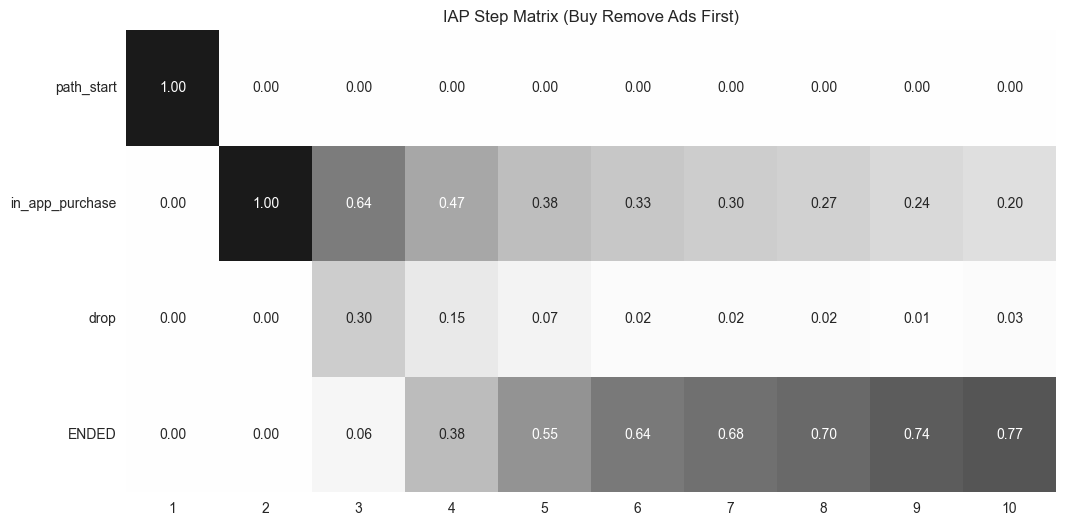

In [10]:
ads_iap = final_data[final_data['first_product_iap'].str.contains('removeads')].reset_index(drop=True)
ads_stream = ads_iap[['user_pseudo_id', 'event_name', 'event_timestamp']]
ads_stream.rename(columns={
    'user_pseudo_id': 'user_id',
    'event_timestamp': 'timestamp',
    'event_name': 'event'
}, inplace=True)

ads_step = Eventstream(ads_stream).step_matrix(
    max_steps=10,
    show_plot=False,
)

ax = ads_step.plot()
fig = ax.get_figure()
fig.set_size_inches(12, 6)
ax.set_title("IAP Step Matrix (Buy Remove Ads First)")
plt.show()

In [11]:
Eventstream(ads_stream).step_sankey(
    max_steps=10,
    show_plot=True,
)

Trong số những người dùng mua IAP gói Remove Ads đầu tiên:
- Khoảng 64% người dùng sẽ mua tiếp gói IAP thứ hai
- Khoảng 30% người dùng sẽ drop
- Khoảng 6% người dùng không drop cũng không mua tiếp gói IAP nào nữa

## Phân tích 64% Users mua tiếp có đặc điểm gì chung?

In [40]:
ads_users_active = ads_iap[ads_iap['event_name'] != 'drop']['user_pseudo_id'].unique().tolist()

In [48]:
ads_active_level = f"""
WITH base AS (
SELECT
    user_pseudo_id,
    MIN(event_timestamp) AS start_level_ts,
    level
FROM `{project_id}.{schema_id}.start_level`
WHERE user_pseudo_id IN {tuple(ads_users_active)}
GROUP BY user_pseudo_id, level
)
, base1 AS (
SELECT
    user_pseudo_id,
    start_level_ts,
    LEAD(start_level_ts) OVER(PARTITION BY user_pseudo_id ORDER BY start_level_ts) AS next_start_level_ts,
    level,
    LEAD(level) OVER(PARTITION BY user_pseudo_id ORDER BY start_level_ts) AS next_level
FROM base
)
SELECT
    s1.user_pseudo_id,
    start_level_ts,
    next_start_level_ts,
    level,
    next_level,
    COUNT(DISTINCT s2.event_timestamp) AS iap_count,
    SUM(event_value_in_usd) AS iap_revenue
FROM base1 s1
LEFT JOIN `{project_id}.{schema_id}.in_app_purchase` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s2.event_timestamp >= s1.start_level_ts
    AND ((s2.event_timestamp <= s1.next_start_level_ts) OR (s1.next_start_level_ts IS NULL))
GROUP BY user_pseudo_id, start_level_ts, next_start_level_ts, level, next_level
ORDER BY user_pseudo_id, start_level_ts
"""
ads_active_level = client.query(ads_active_level).to_dataframe()
ads_active_level['iap_revenue'] = ads_active_level['iap_revenue'].fillna(0)
ads_active_level['user_pseudo_id'].nunique()

211

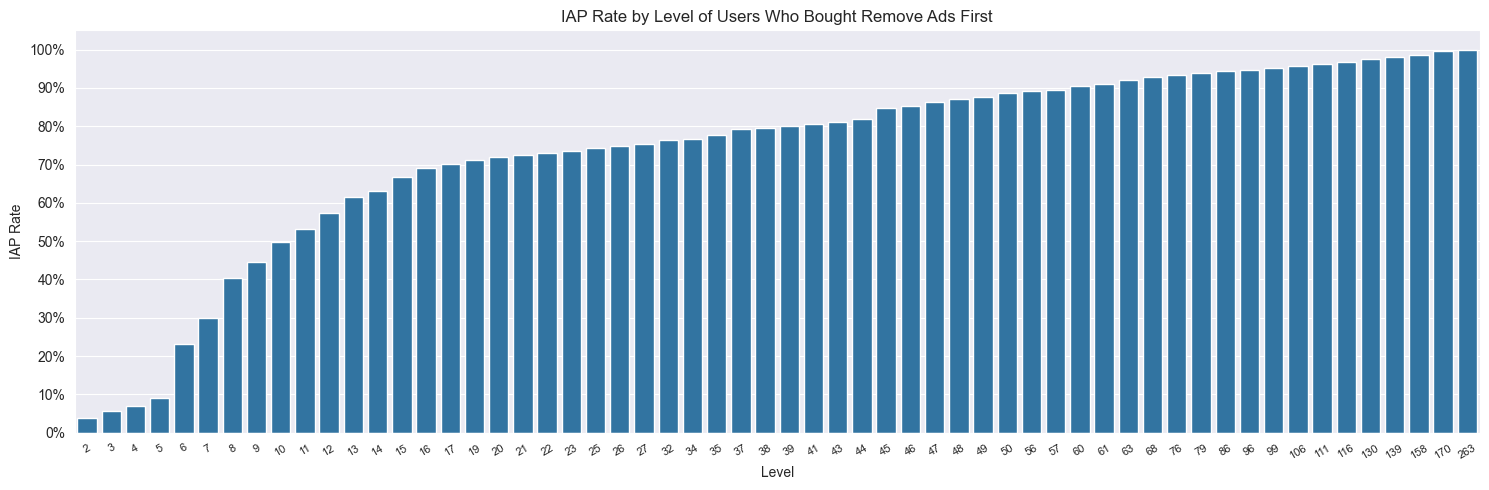

In [123]:
first_level_iap_ads = ads_active_level[ads_active_level['iap_count'] > 0].groupby('user_pseudo_id')['level'].min().reset_index()
first_level_iap_ads = first_level_iap_ads.groupby('level')['user_pseudo_id'].nunique().reset_index()
first_level_iap_ads['total_users_cum'] = first_level_iap_ads['user_pseudo_id'].cumsum()
first_level_iap_ads['iap_rate'] = first_level_iap_ads['total_users_cum'] / (first_level_iap_ads['user_pseudo_id'].sum())

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data= first_level_iap_ads, x='level', y='iap_rate', ax=ax)
ax.set_title('IAP Rate by Level of Users Who Bought Remove Ads First')
ax.set_xlabel('Level')
ax.set_ylabel('IAP Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30, fontsize=8)
plt.tight_layout()
plt.show()

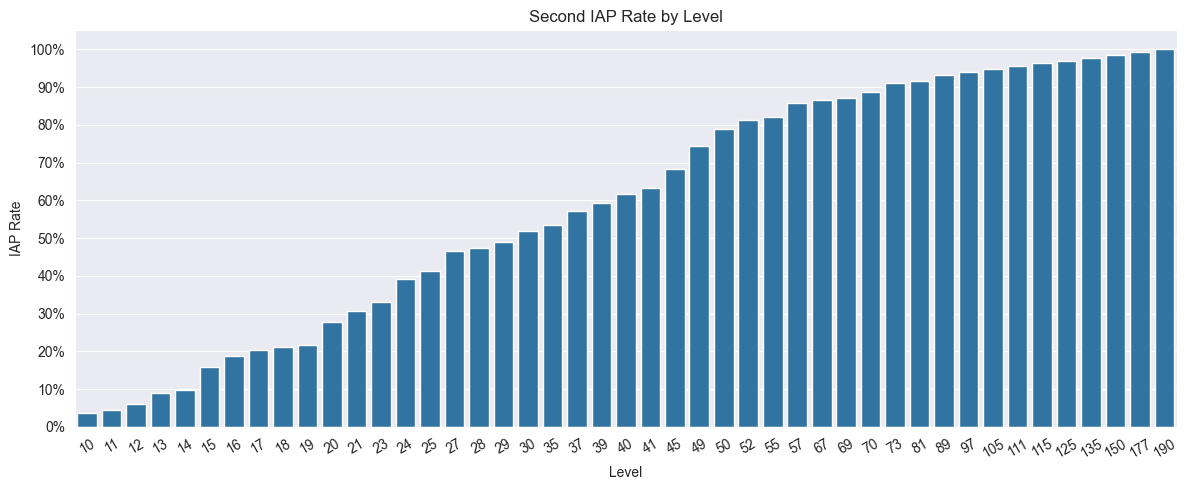

In [124]:
iap_oder = ads_active_level[ads_active_level['iap_count'] > 0].sort_values(by=['user_pseudo_id', 'start_level_ts']).reset_index(drop=True)
iap_oder['iap_order'] = iap_oder.groupby('user_pseudo_id').cumcount() + 1
second_iap = iap_oder[iap_oder['iap_order'] == 2]
second_iap_level = second_iap.groupby('level')['user_pseudo_id'].nunique().reset_index(name='total_users')
second_iap_level['total_users_cum'] = second_iap_level['total_users'].cumsum()
second_iap_level['iap_rate'] = second_iap_level['total_users_cum'] / (second_iap_level['total_users'].sum())

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data= second_iap_level, x='level', y='iap_rate', ax=ax)
ax.set_title('Second IAP Rate by Level')
ax.set_xlabel('Level')
ax.set_ylabel('IAP Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

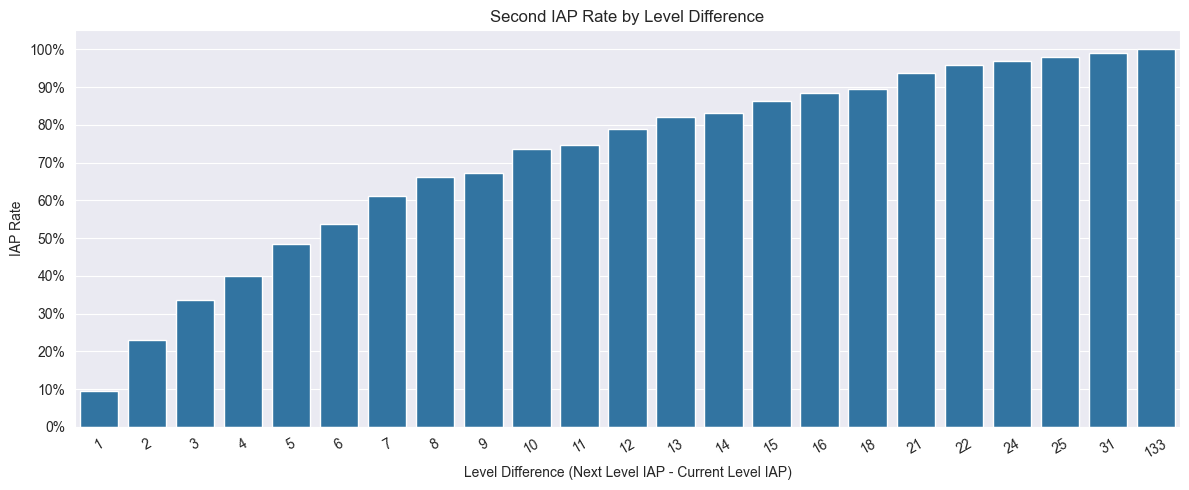

In [125]:
iap_oder['next_level_iap'] = iap_oder.groupby('user_pseudo_id')['level'].shift(-1)
iap_oder['level_diff'] = iap_oder['next_level_iap'] - iap_oder['level']
avg_level_diff = iap_oder[iap_oder['iap_order'] == 2].groupby('level_diff')['user_pseudo_id'].nunique().reset_index(name='total_users')
avg_level_diff['total_users_cum'] = avg_level_diff['total_users'].cumsum()
avg_level_diff['level_diff_mean'] = avg_level_diff['total_users_cum'] / (avg_level_diff['total_users'].sum())

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data= avg_level_diff, x='level_diff', y='level_diff_mean', ax=ax)
ax.set_title('Second IAP Rate by Level Difference')
ax.set_xlabel('Level Difference (Next Level IAP - Current Level IAP)')
ax.set_ylabel('IAP Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Trong số 64% Users mua tiếp gói IAP thứ hai:
- 80% users mua iap lần đầu trước level 45
- 80% users sẽ mua tiếp gói iap thứ hai trước level 55
- 80% users sẽ chơi tiếp khoảng 13 levels rồi mua gói IAP thứ hai.

## Phân tích 30% Users Drop có đặc điểm gì chung?

In [128]:
ads_users_drop = ads_iap[ads_iap['event_name'] == 'drop']['user_pseudo_id'].unique().tolist()
ads_drop_data = ads_iap[ads_iap['user_pseudo_id'].isin(ads_users_drop)].groupby('user_pseudo_id')['event_timestamp'].nunique().reset_index()
users_drop_imme = ads_drop_data[ads_drop_data['event_timestamp'] == 2]['user_pseudo_id'].unique().tolist()

In [13]:
event_list = """
SELECT
    DISTINCT event_name
FROM `{project_id}.{schema_id}.user_fact`
WHERE event_date = '2025-08-08'
"""
event_list = client.query(event_list).to_dataframe()
event_list = event_list['event_name'].tolist()

event_firebase = ['app_clear_data', 'app_update', 'firebase_campaign','in_app_purchased', 'inter_attempt', 'os_update', 'reward_attempt']
event_filter = ['IAP_home_click', 'ad_impression', 'ad_reward', 'ad_inters', 'ad_rewarded', 'all_play_level_time', 'app_exception', 'app_remove', 'first_open', 'reward_completed', 'screen_view', 'session_start', 'user_engagement']
event_ua = [e for e in event_list if re.search(r'_\d+\b', str(e))]
event_list = [e for e in event_list if e not in event_firebase and e not in event_filter and e not in event_ua]
len(event_list)

32

In [14]:
query_ads_drop = f"""
WITH base AS (
SELECT
    s2.event_date AS first_date,
    s2.country,
    s2.platform,
    DATE_DIFF(s1.event_date, s2.event_date, DAY) AS cohort_day,
    s1.*,
    ROW_NUMBER() OVER(PARTITION BY s1.user_pseudo_id ORDER BY s1.event_timestamp ASC) AS iap_order
FROM `{project_id}.{schema_id}.in_app_purchase` s1
JOIN `{project_id}.{schema_id}.first_open` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s1.event_date >= s2.event_date
WHERE s2.user_pseudo_id IN {tuple(users_drop_imme)}
)
, base1 AS (
SELECT
    user_pseudo_id,
    event_timestamp,
    product_id,
FROM base
WHERE iap_order = 1
)
SELECT
  s1.user_pseudo_id,
  s1.event_timestamp AS ts_first_iap,
  product_id AS first_product_iap,
  s2.event_name,
  s2.event_date,
  s2.event_timestamp
FROM base1 s1
LEFT JOIN `{project_id}.{schema_id}.user_fact` s2
  ON s1.user_pseudo_id = s2.user_pseudo_id
  AND s2.event_timestamp >= s1.event_timestamp
WHERE s2.event_name IN {tuple(event_list)}
ORDER BY user_pseudo_id, ts_first_iap, event_timestamp
"""
ads_drop_data = client.query(query_ads_drop).to_dataframe()
ads_drop_data['user_pseudo_id'].nunique()

64

In [24]:
ads_drop_level = f"""
WITH base AS (
SELECT
    user_pseudo_id,
    MIN(event_timestamp) AS start_level_ts,
    level
FROM `{project_id}.{schema_id}.start_level`
WHERE user_pseudo_id IN {tuple(users_drop_imme)}
GROUP BY user_pseudo_id, level
)
, base1 AS (
SELECT
    user_pseudo_id,
    start_level_ts,
    LEAD(start_level_ts) OVER(PARTITION BY user_pseudo_id ORDER BY start_level_ts) AS next_start_level_ts,
    level,
    LEAD(level) OVER(PARTITION BY user_pseudo_id ORDER BY start_level_ts) AS next_level
FROM base
)
SELECT
    s1.user_pseudo_id,
    start_level_ts,
    next_start_level_ts,
    level,
    next_level,
    COUNT(DISTINCT s2.event_timestamp) AS iap_count,
    SUM(event_value_in_usd) AS iap_revenue
FROM base1 s1
LEFT JOIN `{project_id}.{schema_id}.in_app_purchase` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s2.event_timestamp >= s1.start_level_ts
    AND ((s2.event_timestamp <= s1.next_start_level_ts) OR (s1.next_start_level_ts IS NULL))
GROUP BY user_pseudo_id, start_level_ts, next_start_level_ts, level, next_level
ORDER BY user_pseudo_id, start_level_ts
"""
ads_drop_level = client.query(ads_drop_level).to_dataframe()
ads_drop_level['iap_revenue'] = ads_drop_level['iap_revenue'].fillna(0)
ads_drop_level['user_pseudo_id'].nunique()

64

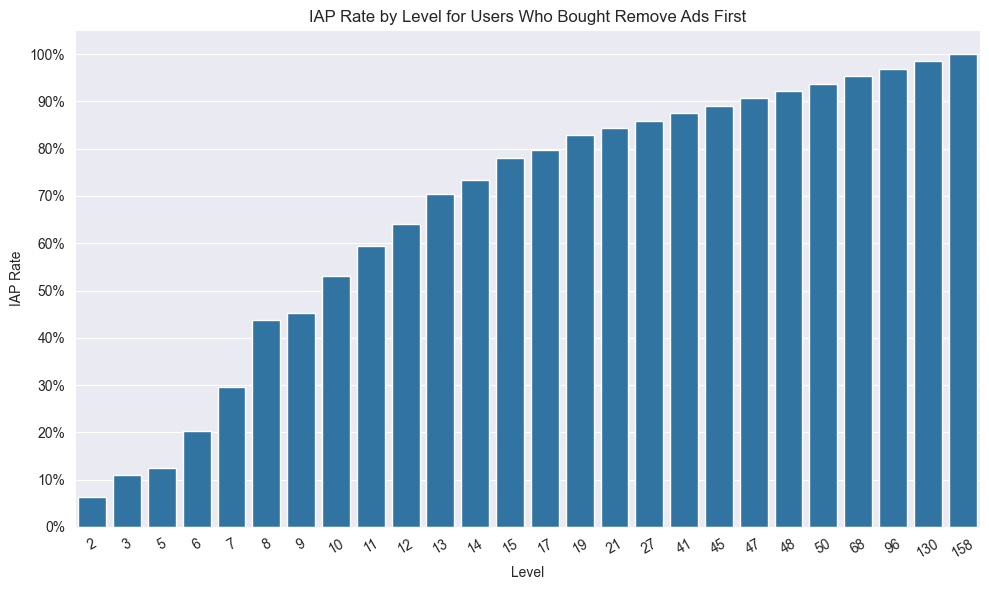

In [129]:
first_level_iap_ads = ads_drop_level[ads_drop_level['iap_count'] > 0].groupby('level')['user_pseudo_id'].nunique().reset_index()
first_level_iap_ads['total_users_cum'] = first_level_iap_ads['user_pseudo_id'].cumsum()
first_level_iap_ads['iap_rate'] = first_level_iap_ads['total_users_cum'] / (first_level_iap_ads['user_pseudo_id'].sum())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data= first_level_iap_ads, x='level', y='iap_rate', ax=ax)
ax.set_title('IAP Rate by Level for Users Who Bought Remove Ads First')
ax.set_xlabel('Level')
ax.set_ylabel('IAP Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

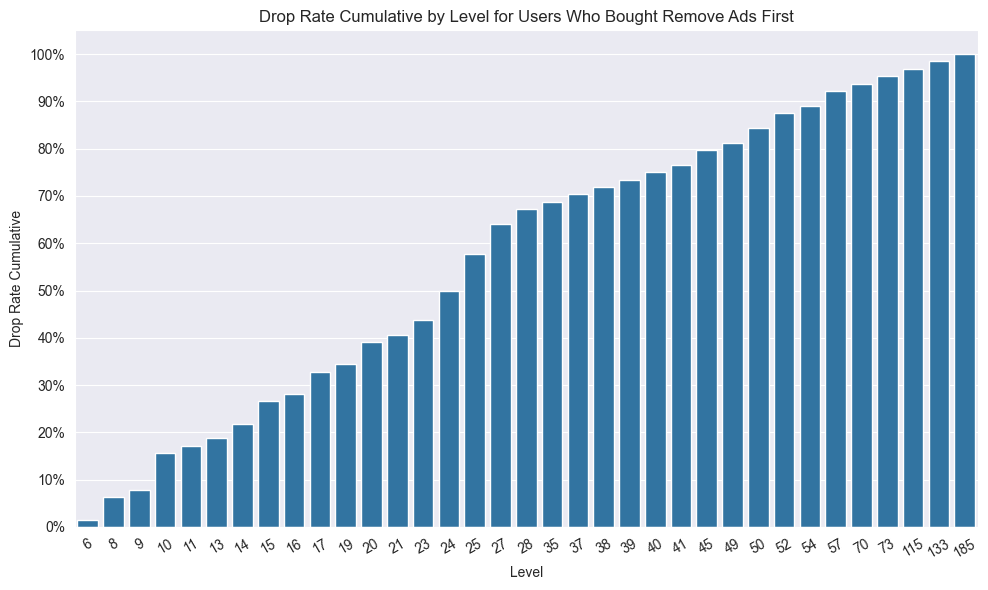

In [131]:
last_level_played = ads_drop_level.groupby('user_pseudo_id')['level'].max().reset_index()
last_level_played = last_level_played.groupby('level')['user_pseudo_id'].nunique().reset_index(name='total_users')
last_level_played['total_users_cum'] = last_level_played['total_users'].cumsum()
last_level_played['drop_rate_cum'] = last_level_played['total_users_cum'] / (last_level_played['total_users'].sum())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data= last_level_played, x='level', y='drop_rate_cum', ax=ax)
ax.set_title('Drop Rate Cumulative by Level for Users Who Bought Remove Ads First')
ax.set_xlabel('Level')
ax.set_ylabel('Drop Rate Cumulative')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

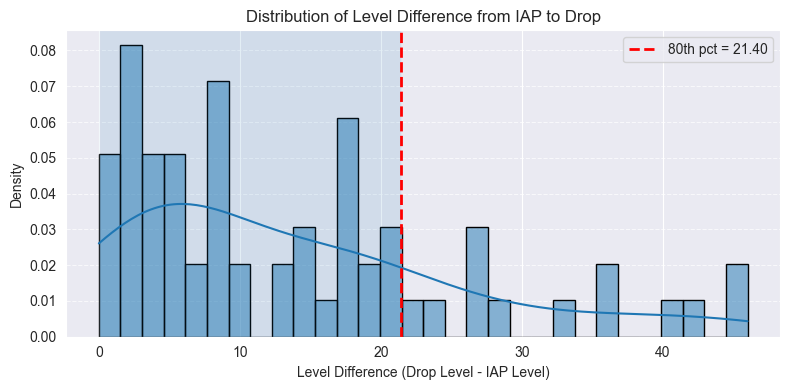

In [83]:
ads_drop_level['level_drop'] = (
    ads_drop_level.groupby('user_pseudo_id')['level']
    .transform('max')
)
iap_to_drop = ads_drop_level[ads_drop_level['iap_count'] > 0].copy()
iap_to_drop['level_diff'] = iap_to_drop['level_drop'] - iap_to_drop['level']

# Tính ngưỡng 75%
q80 = iap_to_drop['level_diff'].dropna().quantile(0.80)

fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(
    data=iap_to_drop,
    x='level_diff',
    bins=30,
    kde=True,
    stat='density',
    edgecolor='black',
    ax=ax
)

# Vẽ đường dọc tại 75th percentile
ax.axvline(q80, linestyle='--', linewidth=2, color='red', label=f'80th pct = {q80:.2f}')

# (tuỳ chọn) tô vùng bên trái ngưỡng để nhấn mạnh “0–75%”
ax.axvspan(iap_to_drop['level_diff'].min(), q80, alpha=0.12)

ax.set_title('Distribution of Level Difference from IAP to Drop')
ax.set_xlabel('Level Difference (Drop Level - IAP Level)')
ax.set_ylabel('Density')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

Trong số 30% Users Drop sau khi mua IAP gói Remove Ads:
- Gần 90% users mua trước level 45
- Gần 90% users drop trước level 57
- 80% users chơi tiếp tối đa khoảng 20 levels trước khi drops


**Kết Luận:**
- Trong số 64% Users mua tiếp gói IAP thứ hai:
    - 80% users mua iap lần đầu trước level 45
    - 80% users sẽ mua tiếp gói iap thứ hai trước level 55
    - 80% users sẽ chơi tiếp khoảng 13 levels rồi mua gói IAP thứ hai

/

- Trong số 30% Users Drop sau khi mua IAP gói Remove Ads:
    - Gần 90% users mua trước level 45
    - Gần 90% users drop trước level 57
    - 80% users chơi tiếp tối đa khoảng 20 levels trước khi drop

****
**Đề xuất:**
- Sau khi users mua gói removeads lần đầu, sẽ bóp tài nguyên khoảng 10 levels tiếp theo
- Nếu sau 10 levels đó mà chưa phát sinh gói IAP thứ 2 thì mở lại rw ads với tuần suất 4-5 levels một lần
- Nếu tiếp tục sau 10 levels vẫn không phát sinh gói IAP thứ 2 thì mở lại full rw ads

# Journey của nhóm mua các gói tài nguyên lần đầu tiên

C:\Users\PC\AppData\Local\Temp\ipykernel_14040\1396579438.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



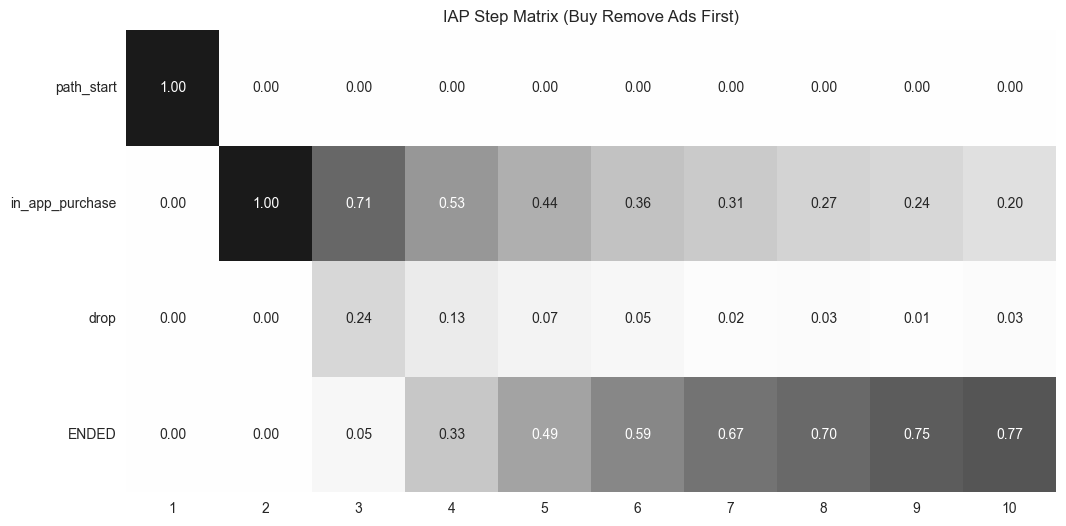

In [134]:

resource_iap = final_data[~final_data['first_product_iap'].str.contains('removeads')].reset_index(drop=True)
resource_stream = resource_iap[['user_pseudo_id', 'event_name', 'event_timestamp']]
resource_stream.rename(columns={
    'user_pseudo_id': 'user_id',
    'event_timestamp': 'timestamp',
    'event_name': 'event'
}, inplace=True)

resource_step = Eventstream(resource_stream).step_matrix(
    max_steps=10,
    show_plot=False,
)

ax = resource_step.plot()
fig = ax.get_figure()
fig.set_size_inches(12, 6)
ax.set_title("IAP Step Matrix (Buy Remove Ads First)")
plt.show()

In [93]:

Eventstream(resource_stream).step_sankey(
    max_steps=10,
    show_plot=True,
)

Trong số những người dùng mua IAP các gói Resources đầu tiên:
- Khoảng 71% người dùng sẽ mua tiếp gói IAP thứ hai
- Khoảng 24% người dùng sẽ drop
- Khoảng 5% người dùng không drop cũng không mua tiếp gói IAP nào nữa

## Phân tích 71% Users mua tiếp có đặc điểm gì chung?

In [135]:
rs_users_active = resource_iap[resource_iap['event_name'] != 'drop']['user_pseudo_id'].unique().tolist()

In [136]:
rs_active_level = f"""
WITH base AS (
SELECT
    user_pseudo_id,
    MIN(event_timestamp) AS start_level_ts,
    level
FROM `{project_id}.{schema_id}.start_level`
WHERE user_pseudo_id IN {tuple(rs_users_active)}
GROUP BY user_pseudo_id, level
)
, base1 AS (
SELECT
    user_pseudo_id,
    start_level_ts,
    LEAD(start_level_ts) OVER(PARTITION BY user_pseudo_id ORDER BY start_level_ts) AS next_start_level_ts,
    level,
    LEAD(level) OVER(PARTITION BY user_pseudo_id ORDER BY start_level_ts) AS next_level
FROM base
)
SELECT
    s1.user_pseudo_id,
    start_level_ts,
    next_start_level_ts,
    level,
    next_level,
    COUNT(DISTINCT s2.event_timestamp) AS iap_count,
    SUM(event_value_in_usd) AS iap_revenue
FROM base1 s1
LEFT JOIN `{project_id}.{schema_id}.in_app_purchase` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s2.event_timestamp >= s1.start_level_ts
    AND ((s2.event_timestamp <= s1.next_start_level_ts) OR (s1.next_start_level_ts IS NULL))
GROUP BY user_pseudo_id, start_level_ts, next_start_level_ts, level, next_level
ORDER BY user_pseudo_id, start_level_ts
"""
rs_active_level = client.query(rs_active_level).to_dataframe()
rs_active_level['iap_revenue'] = rs_active_level['iap_revenue'].fillna(0)
rs_active_level['user_pseudo_id'].nunique()

227

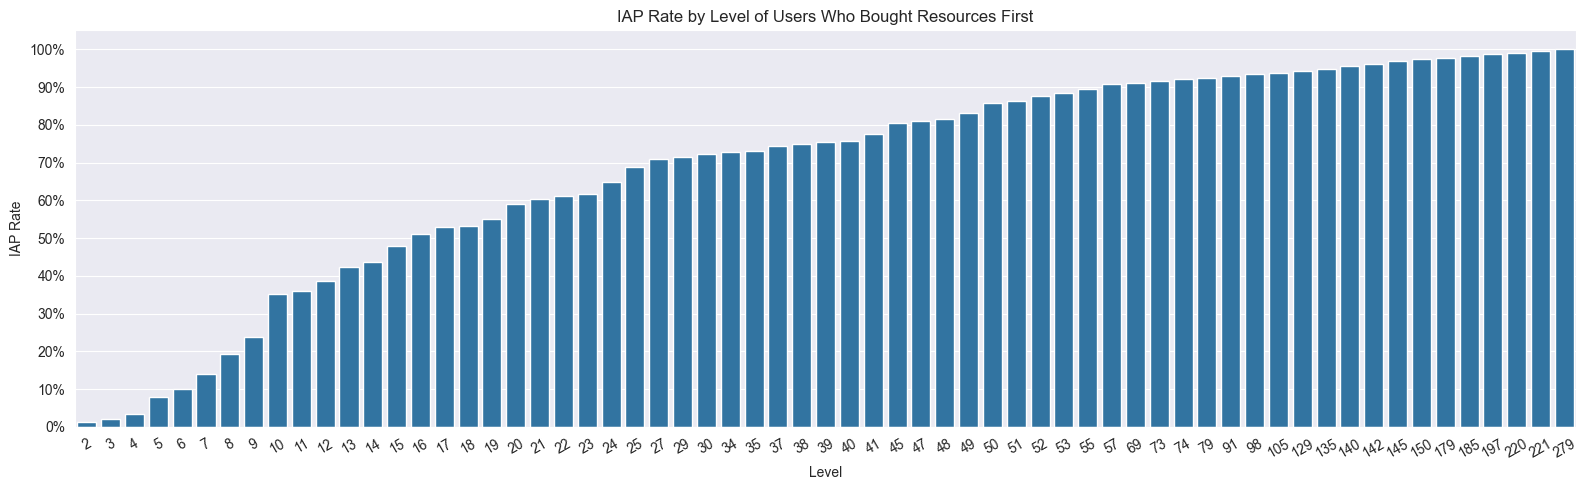

In [137]:
first_level_iap_rs = rs_active_level[rs_active_level['iap_count'] > 0].groupby('user_pseudo_id')['level'].min().reset_index()
first_level_iap_rs = first_level_iap_rs.groupby('level')['user_pseudo_id'].nunique().reset_index()
first_level_iap_rs['total_users_cum'] = first_level_iap_rs['user_pseudo_id'].cumsum()
first_level_iap_rs['iap_rate'] = first_level_iap_rs['total_users_cum'] / (first_level_iap_rs['user_pseudo_id'].sum())

fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data= first_level_iap_rs, x='level', y='iap_rate', ax=ax)
ax.set_title('IAP Rate by Level of Users Who Bought Resources First')
ax.set_xlabel('Level')
ax.set_ylabel('IAP Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

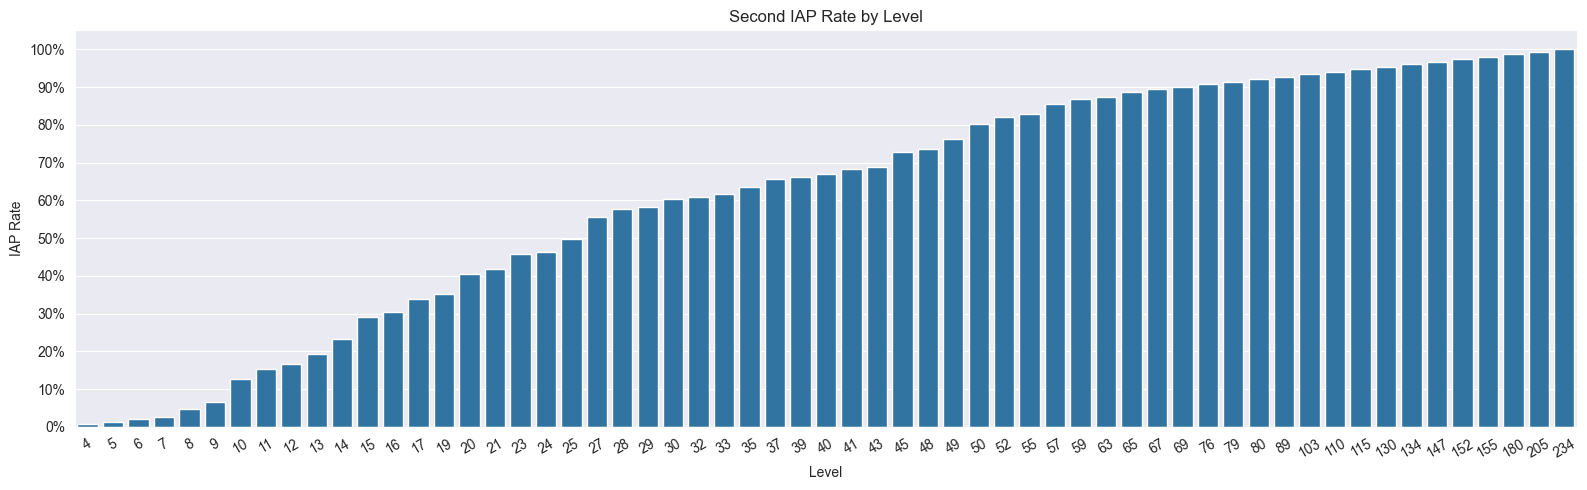

In [139]:
iap_oder = rs_active_level[rs_active_level['iap_count'] > 0].sort_values(by=['user_pseudo_id', 'start_level_ts']).reset_index(drop=True)
iap_oder['iap_order'] = iap_oder.groupby('user_pseudo_id').cumcount() + 1
second_iap = iap_oder[iap_oder['iap_order'] == 2]
second_iap_level = second_iap.groupby('level')['user_pseudo_id'].nunique().reset_index(name='total_users')
second_iap_level['total_users_cum'] = second_iap_level['total_users'].cumsum()
second_iap_level['iap_rate'] = second_iap_level['total_users_cum'] / (second_iap_level['total_users'].sum())

fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(data= second_iap_level, x='level', y='iap_rate', ax=ax)
ax.set_title('Second IAP Rate by Level')
ax.set_xlabel('Level')
ax.set_ylabel('IAP Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

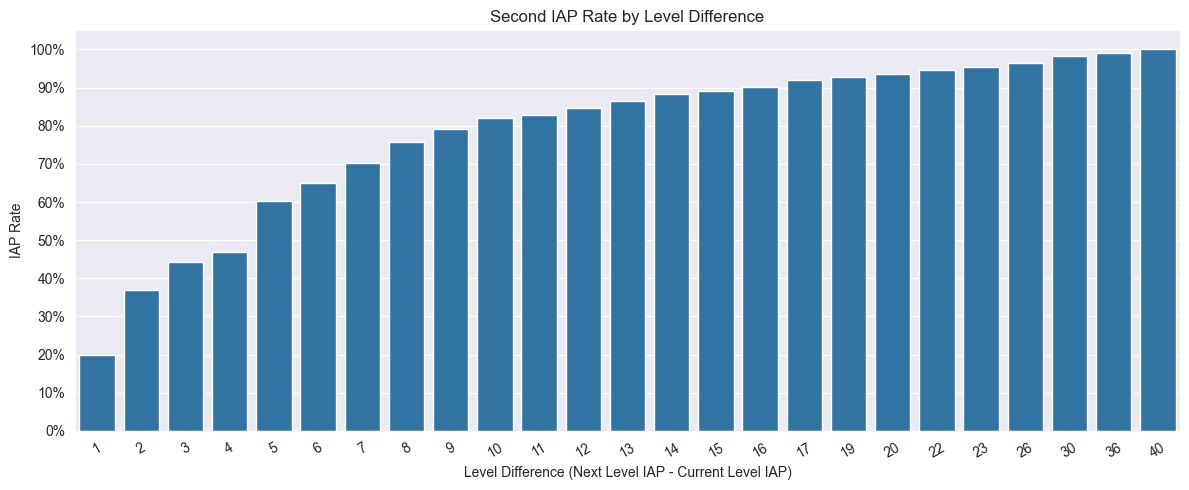

In [141]:
iap_oder['next_level_iap'] = iap_oder.groupby('user_pseudo_id')['level'].shift(-1)
iap_oder['level_diff'] = iap_oder['next_level_iap'] - iap_oder['level']
avg_level_diff = iap_oder[iap_oder['iap_order'] == 2].groupby('level_diff')['user_pseudo_id'].nunique().reset_index(name='total_users')
avg_level_diff['total_users_cum'] = avg_level_diff['total_users'].cumsum()
avg_level_diff['level_diff_mean'] = avg_level_diff['total_users_cum'] / (avg_level_diff['total_users'].sum())

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data= avg_level_diff, x='level_diff', y='level_diff_mean', ax=ax)
ax.set_title('Second IAP Rate by Level Difference')
ax.set_xlabel('Level Difference (Next Level IAP - Current Level IAP)')
ax.set_ylabel('IAP Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Trong số 71% Users mua tiếp gói IAP thứ hai:
- 80% users mua iap lần đầu trước level 47
- 80% users sẽ mua tiếp gói iap thứ hai trước level 50
- 80% users sẽ chơi tiếp khoảng 10 levels rồi mua gói IAP thứ hai.

## Phân tích 24% Users Drop có đặc điểm gì chung?

In [143]:
resource_users_drop = resource_iap[resource_iap['event_name'] == 'drop']['user_pseudo_id'].unique().tolist()
resource_drop_data = resource_iap[resource_iap['user_pseudo_id'].isin(resource_users_drop)].groupby('user_pseudo_id')['event_timestamp'].nunique().reset_index()
users_drop_imme = resource_drop_data[resource_drop_data['event_timestamp'] == 2]['user_pseudo_id'].unique().tolist()

In [144]:
query_rs_drop = f"""
WITH base AS (
SELECT
    s2.event_date AS first_date,
    s2.country,
    s2.platform,
    DATE_DIFF(s1.event_date, s2.event_date, DAY) AS cohort_day,
    s1.*,
    ROW_NUMBER() OVER(PARTITION BY s1.user_pseudo_id ORDER BY s1.event_timestamp ASC) AS iap_order
FROM `{project_id}.{schema_id}.in_app_purchase` s1
JOIN `{project_id}.{schema_id}.first_open` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s1.event_date >= s2.event_date
WHERE s2.user_pseudo_id IN {tuple(users_drop_imme)}
)
, base1 AS (
SELECT
    user_pseudo_id,
    event_timestamp,
    product_id,
FROM base
WHERE iap_order = 1
)
SELECT
  s1.user_pseudo_id,
  s1.event_timestamp AS ts_first_iap,
  product_id AS first_product_iap,
  s2.event_name,
  s2.event_date,
  s2.event_timestamp
FROM base1 s1
LEFT JOIN `{project_id}.{schema_id}.user_fact` s2
  ON s1.user_pseudo_id = s2.user_pseudo_id
  AND s2.event_timestamp >= s1.event_timestamp
WHERE s2.event_name IN {tuple(event_list)}
ORDER BY user_pseudo_id, ts_first_iap, event_timestamp
"""
rs_drop_data = client.query(query_rs_drop).to_dataframe()
rs_drop_data['user_pseudo_id'].nunique()

56

In [145]:
rs_drop_level = f"""
WITH base AS (
SELECT
    user_pseudo_id,
    MIN(event_timestamp) AS start_level_ts,
    level
FROM `{project_id}.{schema_id}.start_level`
WHERE user_pseudo_id IN {tuple(users_drop_imme)}
GROUP BY user_pseudo_id, level
)
, base1 AS (
SELECT
    user_pseudo_id,
    start_level_ts,
    LEAD(start_level_ts) OVER(PARTITION BY user_pseudo_id ORDER BY start_level_ts) AS next_start_level_ts,
    level,
    LEAD(level) OVER(PARTITION BY user_pseudo_id ORDER BY start_level_ts) AS next_level
FROM base
)
SELECT
    s1.user_pseudo_id,
    start_level_ts,
    next_start_level_ts,
    level,
    next_level,
    COUNT(DISTINCT s2.event_timestamp) AS iap_count,
    SUM(event_value_in_usd) AS iap_revenue
FROM base1 s1
LEFT JOIN `{project_id}.{schema_id}.in_app_purchase` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s2.event_timestamp >= s1.start_level_ts
    AND ((s2.event_timestamp <= s1.next_start_level_ts) OR (s1.next_start_level_ts IS NULL))
GROUP BY user_pseudo_id, start_level_ts, next_start_level_ts, level, next_level
ORDER BY user_pseudo_id, start_level_ts
"""
rs_drop_level = client.query(rs_drop_level).to_dataframe()
rs_drop_level['iap_revenue'] = rs_drop_level['iap_revenue'].fillna(0)
rs_drop_level['user_pseudo_id'].nunique()

56

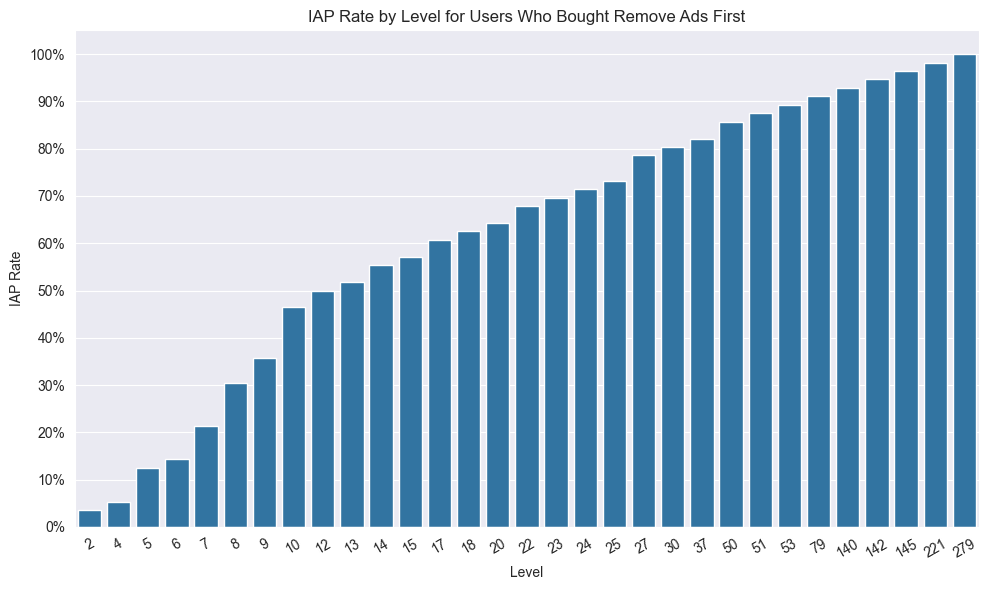

In [146]:
first_level_iap_rs = rs_drop_level[rs_drop_level['iap_count'] > 0].groupby('level')['user_pseudo_id'].nunique().reset_index()
first_level_iap_rs['total_users_cum'] = first_level_iap_rs['user_pseudo_id'].cumsum()
first_level_iap_rs['iap_rate'] = first_level_iap_rs['total_users_cum'] / (first_level_iap_rs['user_pseudo_id'].sum())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data= first_level_iap_rs, x='level', y='iap_rate', ax=ax)
ax.set_title('IAP Rate by Level for Users Who Bought Remove Ads First')
ax.set_xlabel('Level')
ax.set_ylabel('IAP Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

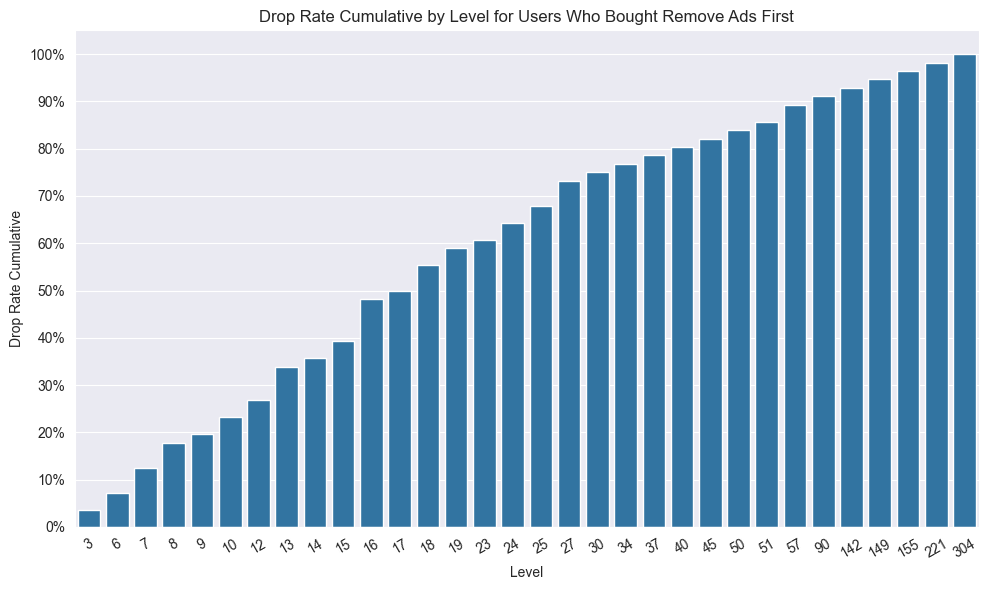

In [148]:
last_level_played = rs_drop_level.groupby('user_pseudo_id')['level'].max().reset_index()
last_level_played = last_level_played.groupby('level')['user_pseudo_id'].nunique().reset_index(name='total_users')
last_level_played['total_users_cum'] = last_level_played['total_users'].cumsum()
last_level_played['drop_rate_cum'] = last_level_played['total_users_cum'] / (last_level_played['total_users'].sum())

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data= last_level_played, x='level', y='drop_rate_cum', ax=ax)
ax.set_title('Drop Rate Cumulative by Level for Users Who Bought Remove Ads First')
ax.set_xlabel('Level')
ax.set_ylabel('Drop Rate Cumulative')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

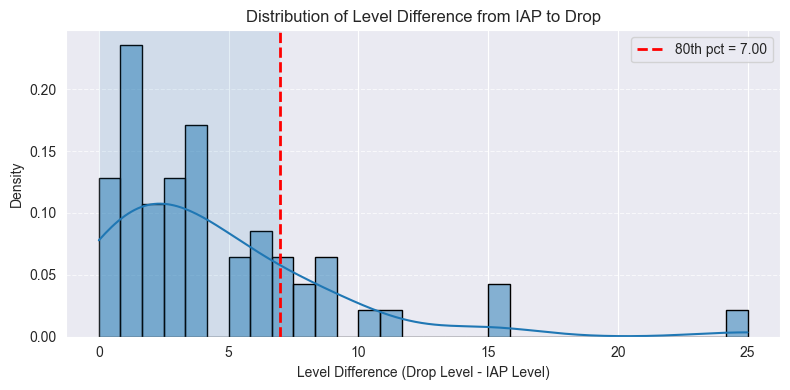

In [150]:
rs_drop_level['level_drop'] = (
    rs_drop_level.groupby('user_pseudo_id')['level']
    .transform('max')
)
iap_to_drop = rs_drop_level[rs_drop_level['iap_count'] > 0].copy()
iap_to_drop['level_diff'] = iap_to_drop['level_drop'] - iap_to_drop['level']

# Tính ngưỡng 75%
q80 = iap_to_drop['level_diff'].dropna().quantile(0.80)

fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(
    data=iap_to_drop,
    x='level_diff',
    bins=30,
    kde=True,
    stat='density',
    edgecolor='black',
    ax=ax
)

ax.axvline(q80, linestyle='--', linewidth=2, color='red', label=f'80th pct = {q80:.2f}')
ax.axvspan(iap_to_drop['level_diff'].min(), q80, alpha=0.12)

ax.set_title('Distribution of Level Difference from IAP to Drop')
ax.set_xlabel('Level Difference (Drop Level - IAP Level)')
ax.set_ylabel('Density')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

Trong số 24% Users Drop sau khi mua IAP các gói Resources:
- Gần 90% users mua trước level 53
- Gần 90% users drop trước level 57
- 80% users chơi tiếp tối đa khoảng 7 levels trước khi drop


**Kết Luận:**
- Trong số 71% Users mua tiếp gói IAP thứ hai:
    - 80% users mua iap lần đầu trước level 47
    - 80% users sẽ mua tiếp gói iap thứ hai trước level 50
    - 80% users sẽ chơi tiếp khoảng 10 levels rồi mua gói IAP thứ hai.

/

- Trong số 24% Users Drop sau khi mua IAP các gói Resources:
    - Gần 90% users mua trước level 53
    - Gần 90% users drop trước level 57
    - 80% users chơi tiếp tối đa khoảng 7 levels trước khi drop

****
**Đề xuất:**
- Sau khi users mua các gói Resources lần đầu, sẽ mở lại tài nguyên khoảng 3 levels 1 lần